In [449]:
#import libraries
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Goal

The goal of this notebook is the same as the other notebook: classify galaxies, stars, and quasars from the SDSS DR16 data. This time however, I made my own query into the data to see if I could make a better model using equal amounts of entries from each class instead of almost equal amounts of stars and galaxies while having 1/5th of the quasars. I also shaved off some of the extra columns which the other dataset had such as RA, DEC, and plate number. The Kaggle dataset also had a range for the u and r field which I did not use. This also gave me the opportunity to download a completely new test set instead of having to split the data.

To summarize the data:

Train Set: 33,333 examples of galaxies, quasars, and stars with spectroscopic data: u, g, r, i, and z as well as photometric data: redshift.

Test Set: 100,000 examples of a mix of galaxies, quasars, and stars with the same spectroscopic and photometric data.

# Step 0: Getting the Data

I am going to include my SQL query into the SDSS DR16 database. This is so that everyone can download this data for themselves if they wanted to. Also nice to have a reminder for myself. The link for the databases is: http://skyserver.sdss.org/dr16/en/tools/search/sql.aspx.

### For the train data

SELECT TOP 33333

&nbsp;&nbsp;&nbsp;&nbsp;p.objid, p.u, p.g, p.r, p.i, p.z

&nbsp;&nbsp;&nbsp;&nbsp;s.class, s.z as redshift, s.mjd

FROM PhotoObj p

JOIN SpecObj s ON s.bestobjid=p.objid

WHERE

&nbsp;&nbsp;&nbsp;&nbsp;s.class='galaxy'

ORDER BY

&nbsp;&nbsp;&nbsp;&nbsp;mjd

I order by the mjd because for my test set shown below I order it by descending order effectively getting the last 100,000 entries while my train set gets training data from the opposite end of the list.

### For the test data

SELECT TOP 100000

&nbsp;&nbsp;&nbsp;&nbsp;p.objid, p.u, p.g, p.r, p.i, p.z

&nbsp;&nbsp;&nbsp;&nbsp;s.class, s.z as redshift, s.mjd

FROM PhotoObj p

JOIN SpecObj s ON s.bestobjid=p.objid

ORDER BY

&nbsp;&nbsp;&nbsp;&nbsp;mjd DESC

# Step 1: Cleaning the Data

In [152]:
#read all the csv files in and join them
sdss_train = pd.read_csv('galaxy_train_data.csv'
                        ).append(pd.read_csv('qso_train_data.csv')
                        ).append(pd.read_csv('star_train_data.csv'))



#clean up the data a little resetting the columns and indexes
sdss_train = sdss_train.reset_index()
sdss_train.columns = sdss_train.iloc[0]
sdss_train = sdss_train.drop([0, 33334, 66668]) #need to drop rows with column names
sdss_train

,objid,u,g,r,i,z,class,redshift,mjd
1,1237648705121747175,18.0294,17.15425,16.87729,16.61592,16.54666,GALAXY,0.06028418,51578
2,1237651203695116448,17.27938,15.50455,14.64715,14.19163,13.79359,GALAXY,0.05354707,51578
3,1237648704047546379,21.00878,18.90549,17.88396,17.41589,16.98518,GALAXY,0.109975,51578
4,1237651801771868404,19.24726,17.30749,16.29784,15.86491,15.54931,GALAXY,0.09581964,51581
5,1237648721218109603,18.38039,17.02025,16.38287,16.03368,15.77508,GALAXY,0.0695365,51581
...,...,...,...,...,...,...,...,...,...
99997,1237654605330186299,19.39952,18.31035,18.27718,18.34993,18.41021,STAR,-0.0001107165,52326
99998,1237651736298127478,20.23496,19.3369,19.02643,18.95843,18.99587,STAR,-1.846749E-05,52326
99999,1237651736298193044,19.30988,18.05188,17.56457,17.36151,17.20525,STAR,0.000788426,52326
100000,1237651736298258451,18.96854,17.46038,17.44714,17.43545,17.78477,STAR,-9.620609E-05,52326


In [153]:
#import the test data
sdss_test = pd.read_csv('test_data.csv')

#apply all changes from training data
sdss_test = sdss_test.reset_index()
sdss_test.columns = sdss_test.iloc[0]
sdss_test = sdss_test.drop(0)
sdss_test

/home/aparker/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (0,1,2,3,4,5,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,objid,u,g,r,i,z,class,redshift,mjd
1,1237665128002879585,21.4922,21.51602,21.26752,22.2176,21.83304,GALAXY,0.0082385,58543
2,1237665128002879718,22.46072,22.06282,21.73407,21.70397,21.70973,QSO,1.590308,58543
3,1237665128002945306,20.87888,20.92679,20.98578,20.72283,20.39952,QSO,1.961972,58543
4,1237665128002945324,21.36017,21.03082,20.96398,20.73165,20.62293,QSO,1.514728,58543
5,1237665128002945328,20.82146,20.60699,20.45501,20.40021,20.16447,QSO,2.037987,58543
...,...,...,...,...,...,...,...,...,...
99996,1237664835397812531,20.8764,20.4527,20.1826,19.9957,19.7861,QSO,2.10302,58437
99997,1237664835397813066,22.1983,22.1043,21.5805,21.4155,20.9223,QSO,1.36027,58437
99998,1237664835397813206,25.3269,23.7458,22.1555,20.748,19.9381,GALAXY,0.646906,58437
99999,1237664835397813263,24.7042,23.6214,22.1289,20.7639,20.1857,STAR,0.000413334,58437


Now time to look at some summary statistics of the data.

In [154]:
display(sdss_train.info())
display(sdss_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99999 entries, 1 to 100001
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   objid     99999 non-null  object
 1   u         99999 non-null  object
 2   g         99999 non-null  object
 3   r         99999 non-null  object
 4   i         99999 non-null  object
 5   z         99999 non-null  object
 6   class     99999 non-null  object
 7   redshift  99999 non-null  object
 8   mjd       99999 non-null  object
dtypes: object(9)
memory usage: 7.6+ MB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 1 to 100000
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   objid     100000 non-null  object
 1   u         100000 non-null  object
 2   g         100000 non-null  object
 3   r         100000 non-null  object
 4   i         100000 non-null  object
 5   z         100000 non-null  object
 6   class     100000 non-null  object
 7   redshift  100000 non-null  object
 8   mjd       100000 non-null  object
dtypes: object(9)
memory usage: 7.6+ MB


None

From info, we can see that they are all object datatype when everything but class should be float or int.

In [155]:
sdss_train[['objid','u','g','r','i','z','redshift','mjd']] = sdss_train[['objid','u','g','r','i','z','redshift','mjd']].astype('float')
sdss_test[['objid','u','g','r','i','z','redshift','mjd']] = sdss_test[['objid','u','g','r','i','z','redshift','mjd']].astype('float')
display(sdss_train.dtypes)
display(sdss_test.dtypes)

0
objid       float64
u           float64
g           float64
r           float64
i           float64
z           float64
class        object
redshift    float64
mjd         float64
dtype: object

0
objid       float64
u           float64
g           float64
r           float64
i           float64
z           float64
class        object
redshift    float64
mjd         float64
dtype: object

In [156]:
display(sdss_train.describe())
display(sdss_test.describe())

,objid,u,g,r,i,z,redshift,mjd
count,9.999900e+04,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,1.237657e+18,15.880006,14.866704,15.312133,14.723147,14.399045,0.454910,51985.181902
std,7.784687e+12,207.728488,202.815871,173.487825,179.167602,181.940801,0.716282,258.405341
min,1.237646e+18,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-0.010875,51578.000000
25%,1.237651e+18,19.058755,17.949945,17.235125,16.840030,16.560565,0.000098,51791.000000
50%,1.237655e+18,19.789100,18.810200,18.265230,17.953020,17.677810,0.103159,51929.000000
75%,1.237663e+18,20.741825,19.844620,19.353065,19.052685,18.905130,0.661663,52209.000000
max,1.237680e+18,29.898640,30.018900,31.698160,30.980870,28.721100,7.003870,52620.000000


,objid,u,g,r,i,z,redshift,mjd
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.237667e+18,22.599644,21.910349,21.081731,20.501972,20.127982,1.022483,58482.791110
std,7.292618e+12,1.865669,1.583743,1.090814,0.932094,1.034956,0.844807,29.214972
min,1.237650e+18,15.698520,14.649000,13.988780,13.696190,12.310930,-0.011098,58437.000000
25%,1.237664e+18,21.322550,20.942098,20.607950,20.195335,19.621320,0.543829,58456.000000
50%,1.237665e+18,22.240570,21.771450,21.338740,20.607520,19.962245,0.837801,58485.000000
75%,1.237670e+18,23.945277,23.114593,21.767555,21.026560,20.791323,1.523265,58511.000000
max,1.237681e+18,28.622430,29.292220,29.840190,27.858500,26.926120,7.030458,58543.000000


It looks like some of the values may have been too small to be and formatted as -9999 by the SDSS. We can go ahead and fix that.

It also looks like the mean of the test set is different than the training data which means that it will be a good test of our model since the values will be completely different.

In [157]:
small_u = sdss_train.where(sdss_train['u'] == -9999).dropna()
sdss_train = sdss_train.drop(index=small_u.index)

small_z = sdss_train.where(sdss_train['z'] == -9999).dropna()
sdss_train = sdss_train.drop(index=small_z.index)

sdss_train.describe()

,objid,u,g,r,i,z,redshift,mjd
count,9.995500e+04,99955.000000,99955.000000,99955.000000,99955.000000,99955.000000,99955.000000,99955.000000
mean,1.237657e+18,20.188307,18.974096,18.317341,17.928568,17.704565,0.454914,51985.269151
std,7.784891e+12,1.909676,1.675270,1.568923,1.492856,1.542130,0.716335,258.396132
min,1.237646e+18,11.960910,12.374760,10.208380,9.270081,10.616260,-0.010875,51578.000000
25%,1.237651e+18,19.059870,17.952020,17.235950,16.841025,16.561540,0.000098,51791.000000
50%,1.237655e+18,19.789630,18.811040,18.266360,17.954240,17.678740,0.103140,51929.000000
75%,1.237663e+18,20.742480,19.845405,19.353330,19.052975,18.905385,0.661725,52209.000000
max,1.237680e+18,29.898640,30.018900,31.698160,30.980870,28.721100,7.003870,52620.000000


In [158]:
sdss_train.head(10)

,objid,u,g,r,i,z,class,redshift,mjd
1,1.237649e+18,18.02940,17.15425,16.87729,16.61592,16.54666,GALAXY,0.060284,51578.0
2,1.237651e+18,17.27938,15.50455,14.64715,14.19163,13.79359,GALAXY,0.053547,51578.0
3,1.237649e+18,21.00878,18.90549,17.88396,17.41589,16.98518,GALAXY,0.109975,51578.0
4,1.237652e+18,19.24726,17.30749,16.29784,15.86491,15.54931,GALAXY,0.095820,51581.0
5,1.237649e+18,18.38039,17.02025,16.38287,16.03368,15.77508,GALAXY,0.069537,51581.0
6,1.237649e+18,20.50915,18.63227,17.71551,17.30176,16.98733,GALAXY,0.091000,51585.0
7,1.237649e+18,20.48706,18.90289,17.79595,17.33059,16.99898,GALAXY,0.231614,51585.0
8,1.237649e+18,20.01231,18.27888,17.35994,16.84805,16.46231,GALAXY,0.084496,51585.0
9,1.237654e+18,18.87259,17.75566,17.31867,17.06793,16.97463,GALAXY,0.021177,51608.0
10,1.237654e+18,17.26423,16.07450,15.46077,15.06488,14.79800,GALAXY,0.062953,51608.0


It looks like our data is pretty cleaned up. From the description of the data, it looks like our spectral qualities of the data are pretty similar which probably means there is some multicollinearity. This also appeared in the last dataset. 

Now, I will drop the objid and mjd columns as they are not features of the objects we are trying to predict.

In [159]:
sdss_train = sdss_train.drop(columns=['objid','mjd'])
sdss_test = sdss_test.drop(columns=['objid','mjd'])
sdss_train

,u,g,r,i,z,class,redshift
1,18.02940,17.15425,16.87729,16.61592,16.54666,GALAXY,0.060284
2,17.27938,15.50455,14.64715,14.19163,13.79359,GALAXY,0.053547
3,21.00878,18.90549,17.88396,17.41589,16.98518,GALAXY,0.109975
4,19.24726,17.30749,16.29784,15.86491,15.54931,GALAXY,0.095820
5,18.38039,17.02025,16.38287,16.03368,15.77508,GALAXY,0.069537
...,...,...,...,...,...,...,...
99997,19.39952,18.31035,18.27718,18.34993,18.41021,STAR,-0.000111
99998,20.23496,19.33690,19.02643,18.95843,18.99587,STAR,-0.000018
99999,19.30988,18.05188,17.56457,17.36151,17.20525,STAR,0.000788
100000,18.96854,17.46038,17.44714,17.43545,17.78477,STAR,-0.000096


# Step 2: Exploratory Data Analysis

We already saw from above that there is the same amount of examples for each feature, 99,955. Let's look at a pair plot and see if there are any correlations between the variables. 

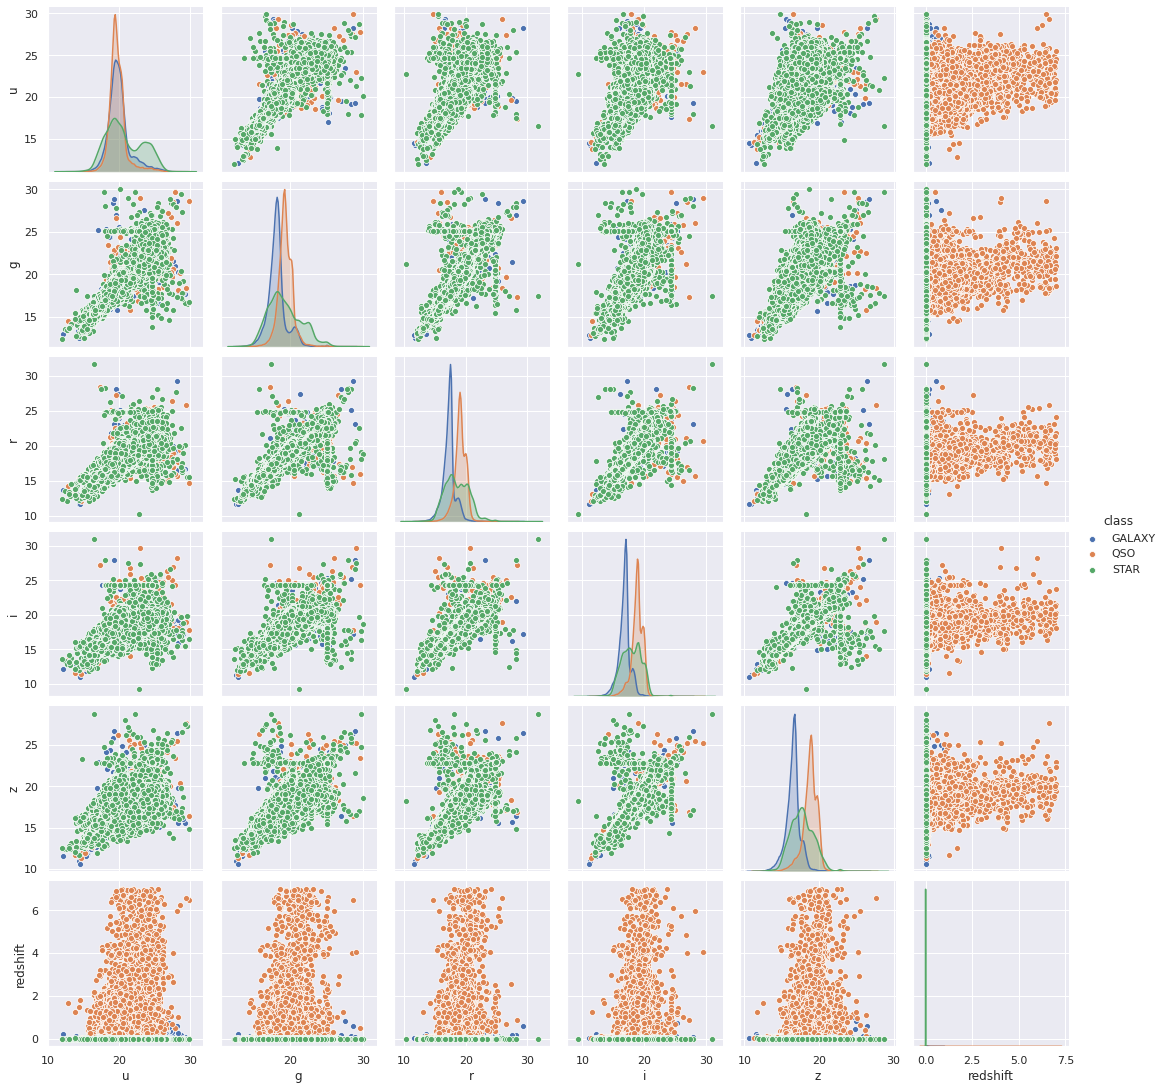

In [72]:
sns.set(style='darkgrid')
sns.pairplot(sdss_train, hue='class')
plt.show()

It appears that all of the photometric qualities of the objects are multicollinear. This didn't prove to be an issue in the last model which I fit for logistic regression, but I will test two models: one with all the features and one reduced with PCA.

The redshift appears to be skewed higher due to the quasars which means that I will probably want to use RobustScaler again.

In [103]:
#Filter each class
stars = sdss_train[sdss_train['class'] == 'STAR']
quasars = sdss_train[sdss_train['class'] == 'QSO']
galaxies = sdss_train[sdss_train['class'] == 'GALAXY']

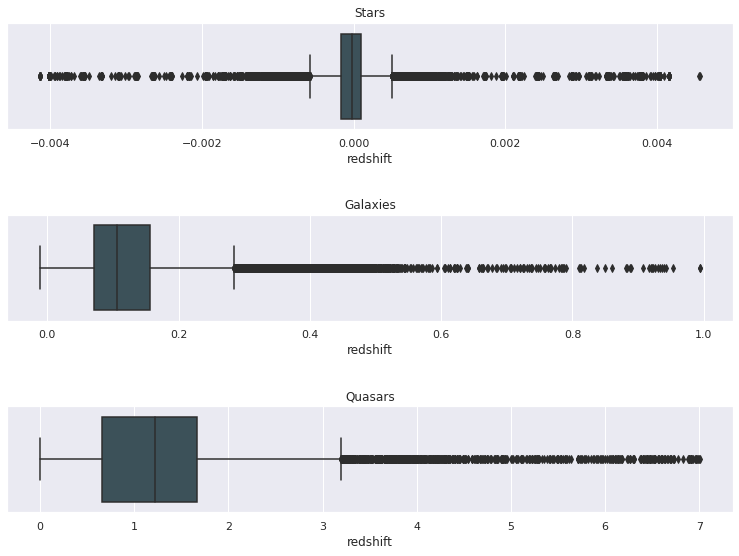

In [106]:
sns.set(style='darkgrid', palette='GnBu_d')
fig, axs = plt.subplots(nrows=3)
fig = plt.gcf()
fig.set_size_inches(13,9)
plt.subplots_adjust(hspace=0.8)
sns.boxplot(stars['redshift'], ax=axs[0]).set_title('Stars')
sns.boxplot(galaxies['redshift'], ax=axs[1]).set_title('Galaxies')
sns.boxplot(quasars['redshift'], ax=axs[2]).set_title('Quasars')
plt.show()

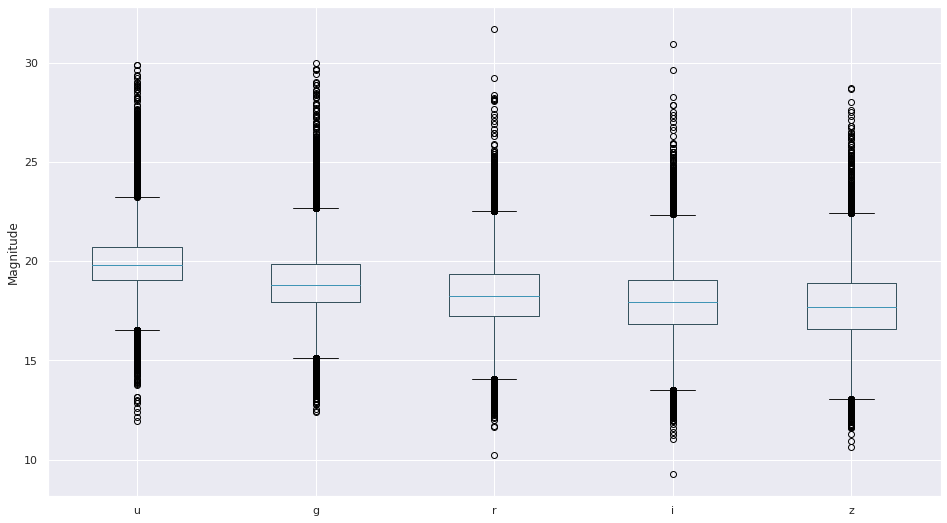

In [116]:
ax2 = sdss_train[['u','g','r','i','z']].plot(kind='box',figsize=(16,9))
ax2.set_ylabel('Magnitude')
plt.show()

It appears to be about the same distribution of redshift for each class. This means that the last dataset was a pretty representative sample of the classes. It also makes sense now how some of the redshift values may be seen as outliers since the quasar's redshift goes up to 7.

It appears the distribution of u, g, r, i, and z are pretty similar which is good.

We'll look at the correlation now.

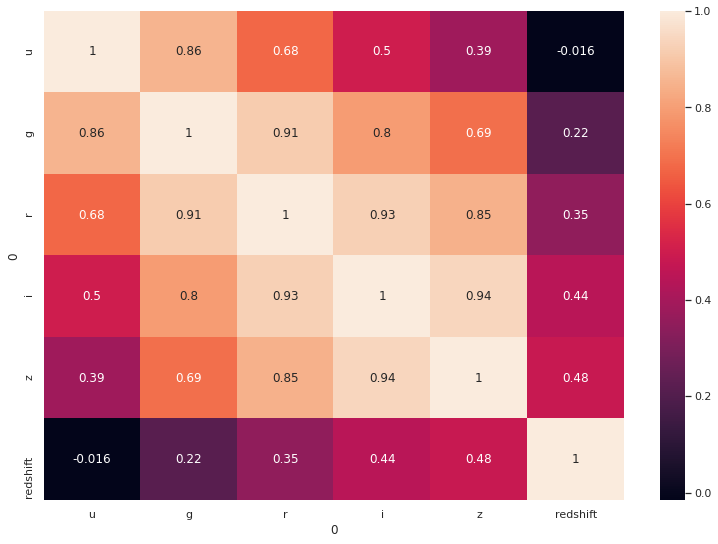

In [117]:
sdss_train_corr = sdss_train.corr()
fig = plt.gcf()
fig.set_size_inches(13,9)
sns.heatmap(sdss_train_corr, annot=True)
plt.show()

We see a high correlation between the photometric qualities again which signals towards multicollinearity. This time I will calculate the VIF to see if it is quantitatively apparent.

In [128]:
sdss_with_const = add_constant(sdss_train.drop(columns='class'))

pd.Series([variance_inflation_factor(sdss_with_const.values, i) for i in range(sdss_with_const.shape[1])],
         index=sdss_with_const.columns)

const       203.901082
u             5.730507
g            16.325544
r            17.733492
i            19.270947
z            10.002802
redshift      1.404290
dtype: float64

In [129]:
sdss_without_i = add_constant(sdss_train.drop(columns=['class','i']))

pd.Series([variance_inflation_factor(sdss_without_i.values, i) for i in range(sdss_without_i.shape[1])],
         index=sdss_without_i.columns)

const       197.789827
u             5.627945
g            16.244888
r            13.436369
z             4.804661
redshift      1.400255
dtype: float64

In [130]:
sdss_without_g = add_constant(sdss_train.drop(columns=['class','i','g']))

pd.Series([variance_inflation_factor(sdss_without_g.values, i) for i in range(sdss_without_g.shape[1])],
         index=sdss_without_g.columns)

const       194.406652
u             2.515127
r             7.151735
z             4.803049
redshift      1.398112
dtype: float64

It appears that the VIF is high for g, r, i, and z while u and redshift do not exhibit multicollinearity. I will apply PCA to try to combine i, g, r, and z to only two dimensions. I want to test my model using the method of just dropping the features to lower the VIF as shown above, lower the dimensionality of the features using PCA, and using all of the features to see if there is a difference between model accuracy.

# Step 3: Feature Engineering

In [382]:
train_data = sdss_train[['u', 'g', 'r', 'i', 'z', 'redshift']]

#1 = Galaxies, 2 = QSO, 3 = Star
train_target = pd.factorize(sdss_train['class'])[0]

test_data = sdss_test[['u', 'g', 'r', 'i', 'z', 'redshift']]

test_target_original = pd.factorize(sdss_test['class'])[0]

In [383]:
#Scale the data
robust_scaler = RobustScaler()

#both df have the same features
features = train_data.columns

train_data = robust_scaler.fit_transform(train_data)
test_data = robust_scaler.transform(test_data)

#Put the data back into dataframes
train_data = pd.DataFrame(train_data, columns=features)
test_data = pd.DataFrame(test_data, columns=features)

display(train_data, test_data)

,u,g,r,i,z,redshift
0,-1.046131,-0.875041,-0.656032,-0.605041,-0.483001,-0.064773
1,-1.491879,-1.746338,-1.709287,-1.701038,-1.657597,-0.074956
2,0.724559,0.049884,-0.180601,-0.243383,-0.295907,0.010331
3,-0.322339,-0.794107,-0.929696,-0.944565,-0.908520,-0.011064
4,-0.837532,-0.945814,-0.889538,-0.868266,-0.812195,-0.050789
...,...,...,...,...,...,...
99950,-0.231848,-0.264442,0.005110,0.178887,0.312081,-0.156056
99951,0.264666,0.277735,0.358967,0.453984,0.561953,-0.155916
99952,-0.285123,-0.400954,-0.331443,-0.267967,-0.202014,-0.154697
99953,-0.487986,-0.713357,-0.386903,-0.234540,0.045238,-0.156034


,u,g,r,i,z,redshift
0,1.011863,1.428648,1.417393,1.927422,1.772429,-0.143437
1,1.587468,1.717443,1.637736,1.695215,1.719819,2.247744
2,0.647357,1.117443,1.284333,1.251651,1.160819,2.809487
3,0.933395,1.172387,1.274037,1.255639,1.256137,2.133511
4,0.613232,0.948539,1.033660,1.105798,1.060535,2.924378
...,...,...,...,...,...,...
99995,0.645889,0.867040,0.904991,0.922905,0.899121,3.022668
99996,1.431520,1.739335,1.565232,1.564805,1.383880,1.900057
99997,3.290858,2.606332,1.836784,1.263030,0.963955,0.821862
99998,2.920778,2.540603,1.824217,1.270232,1.069576,-0.155264


Now I will appy PCA on the i, g, r, and z columns.

In [384]:
pca = PCA(n_components=2)

principal_df = train_data.append(test_data)

pcomp = principal_df[['g','i','r','z']]
principalComponents = pca.fit_transform(pcomp)

principal_df['i,g,r_PCA1'] = principalComponents[:,0]
principal_df['i,g,r_PCA2'] = principalComponents[:,1]

principal_df = principal_df.drop(columns=['i','g','r','z'])

train_data_principal = principal_df.iloc[0:99955]
test_data_principal = principal_df.iloc[99955:199955]

display(train_data_principal, test_data_principal)

,u,redshift,"i,g,r_PCA1","i,g,r_PCA2"
0,-1.046131,-0.064773,2.681588,0.057469
1,-1.491879,-0.074956,4.705599,-0.535376
2,0.724559,0.010331,1.626245,-0.299817
3,-0.322339,-0.011064,3.085653,-0.399947
4,-0.837532,-0.050789,3.089155,-0.207337
...,...,...,...,...
99950,-0.231848,-0.156056,1.306544,0.460787
99951,0.264666,-0.155916,0.567326,0.365018
99952,-0.285123,-0.154697,1.960668,0.050941
99953,-0.487986,-0.156034,2.074589,0.428999


,u,redshift,"i,g,r_PCA1","i,g,r_PCA2"
0,1.011863,-0.143437,-1.814948,0.940311
1,1.587468,2.247744,-1.986151,0.624619
2,0.647357,2.809487,-1.017245,0.498457
3,0.933395,2.133511,-1.084917,0.523194
4,0.613232,2.924378,-0.679593,0.489506
...,...,...,...,...
99995,0.645889,3.022668,-0.419397,0.369926
99996,1.431520,1.900057,-1.775357,0.346568
99997,3.290858,0.821862,-2.162444,-0.615316
99998,2.920778,-0.155264,-2.158779,-0.501910


Now that I have applied PCA to both the training data and the test data, I will look at the VIF again and see if it has lowered for each feature.

In [368]:
train_with_const = add_constant(train_data_principal)

pd.Series([variance_inflation_factor(train_with_const.values, i) for i in range(train_with_const.shape[1])],
         index=train_with_const.columns)

const         7.458765
u             5.329002
redshift      1.400459
i,g,r_PCA1    4.638358
i,g,r_PCA2    2.746204
dtype: float64

In [243]:
test_with_const = add_constant(test_data_principal)

pd.Series([variance_inflation_factor(test_with_const.values, i) for i in range(test_with_const.shape[1])],
         index=test_with_const.columns)

const         6.622461
u             3.337043
redshift      1.227229
i,g,r_PCA1    2.135576
i,g,r_PCA2    2.067630
dtype: float64

Reducing the dimensionality from 6 to 4 dimensions lowered the VIF for both of the datasets. While the training set still has a VIF of a little greater than 5 for u, I think that it is close enough to let it be.

Now onto training the model.

# Step 4: Training the Model

So now I will actually split the test data into a cross-validation set and a test set so that I can test all three of the methods I want to without fitting it for the test set. I'm pulling from the test data because I made my training data have the same amount of each class to hopefully make the model understand each class better. I can also pull more test data easily from the SDSS website if I wanted to.

In [369]:
cv_data, test_data, cv_target, test_target = train_test_split(test_data, test_target_original, 
                                                              test_size=0.40, random_state=0)

## Applying Logistic Regression with all features

Classification Test Score: 0.72365 

Train Score: 0.9662348056625482 

Classification Performance:
               precision    recall  f1-score   support

           0       0.97      0.24      0.38     21535
           1       0.65      0.99      0.79     29113
           2       0.91      1.00      0.95      9352

    accuracy                           0.72     60000
   macro avg       0.84      0.74      0.71     60000
weighted avg       0.81      0.72      0.67     60000



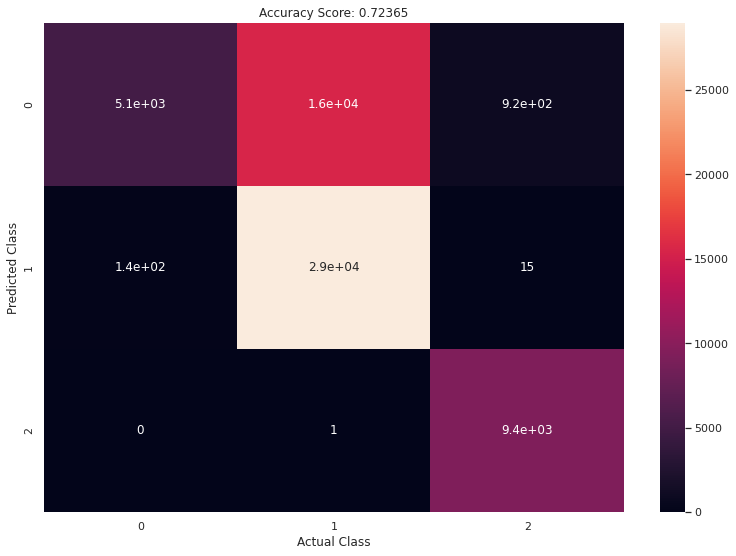

In [467]:
logRegression_allfeat = LogisticRegression()

logRegression_allfeat.fit(train_data, train_target)
predictions = logRegression_allfeat.predict(cv_data)

test_accuracy = logRegression_allfeat.score(cv_data, cv_target)
train_accuracy = logRegression_allfeat.score(train_data, train_target)

print('Classification Test Score:', test_accuracy ,'\n')
print('Train Score:', train_accuracy, '\n')
print('Classification Performance:\n', classification_report(cv_target, predictions))

cm = confusion_matrix(cv_target, predictions)

fig = plt.gcf()
fig.set_size_inches(13,9)
sns.heatmap(cm, annot=True).set_title('Accuracy Score: {}'.format(test_accuracy))
plt.xlabel('Actual Class')
plt.ylabel('Predicted Class')

plt.show()

The classification test score ended up only being 72% which is not the best. It appears that the model is overfitting since the train score is 96% which is much greater than the test score. It appears that the stars are resulting in a lot of false negatives resulting in a low recall score. The galaxies are on the other end have a high recall but low precision. It appears that a lot of the stars are being classified as galaxies and vice-versa. This may be a result of the u, g, r, i, and z being very similarly distributed for both of them as well as their redshifts. The quasars do not suffer from this because of their high redshift values which allows them to be differentiated from the rest of the classes.

## Applying Logistic Regression with dropped features

Classification Test Score: 0.7325333333333334 

Train Score: 0.9644640088039618 

Classification Performance:
               precision    recall  f1-score   support

           0       0.97      0.24      0.38     21535
           1       0.65      0.99      0.79     29113
           2       0.91      1.00      0.95      9352

    accuracy                           0.72     60000
   macro avg       0.84      0.74      0.71     60000
weighted avg       0.81      0.72      0.67     60000



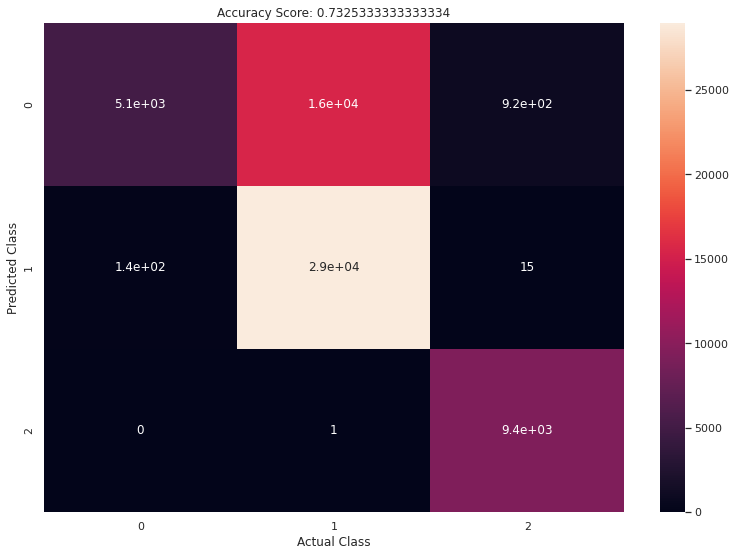

In [419]:
train_data_dropped= train_data[['u','z','redshift']]
cv_data_dropped= cv_data[['u','z','redshift']]

logRegression_dropped = LogisticRegression()

logRegression_dropped.fit(train_data_dropped, train_target)
predictions_droppped = logRegression_dropped.predict(cv_data_dropped)

test_accuracy = logRegression_dropped.score(cv_data_dropped, cv_target)
train_accuracy = logRegression_dropped.score(train_data_dropped, train_target)

print('Classification Test Score:', test_accuracy ,'\n')
print('Train Score:', train_accuracy, '\n')
print('Classification Performance:\n', classification_report(cv_target, predictions))

cm = confusion_matrix(cv_target, predictions)

fig = plt.gcf()
fig.set_size_inches(13,9)
sns.heatmap(cm, annot=True).set_title('Accuracy Score: {}'.format(test_accuracy))
plt.xlabel('Actual Class')
plt.ylabel('Predicted Class')

plt.show()


In [416]:
cv_data_principal, _, cv_target_principal, _ = train_test_split(test_data_principal, 
                                                                test_target_original, test_size=0.40, 
                                                                random_state=0)

## Applying Logistic Regression with PCA

Classification Test Score: 0.7291666666666666 

Train Score: 0.9194237406833075 

Classification Performance:
               precision    recall  f1-score   support

           0       0.97      0.24      0.38     21535
           1       0.65      0.99      0.79     29113
           2       0.91      1.00      0.95      9352

    accuracy                           0.72     60000
   macro avg       0.84      0.74      0.71     60000
weighted avg       0.81      0.72      0.67     60000



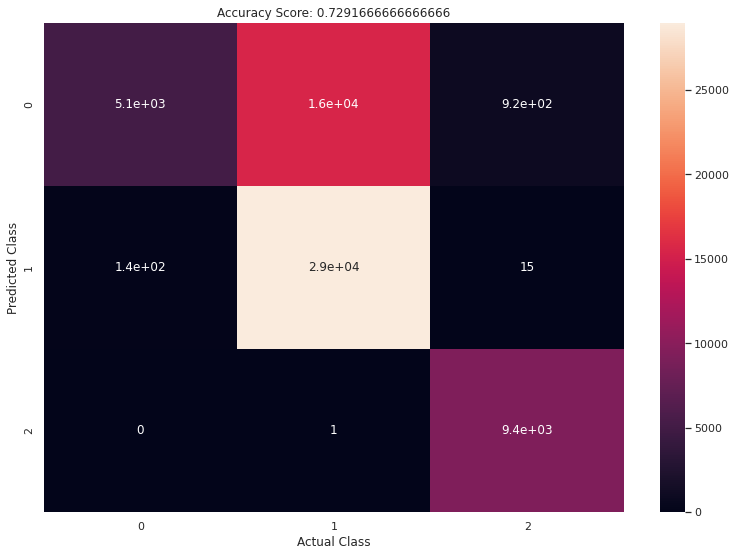

In [440]:
logRegression_pca = LogisticRegression(C = 0.01)

logRegression_pca.fit(train_data_principal, train_target)
predictions_pca = logRegression_pca.predict(cv_data_principal)

test_accuracy = logRegression_pca.score(cv_data_principal, cv_target_principal)
train_accuracy = logRegression_pca.score(train_data_principal, train_target)

print('Classification Test Score:', test_accuracy ,'\n')
print('Train Score:', train_accuracy, '\n')
print('Classification Performance:\n', classification_report(cv_target_principal, predictions))

cm = confusion_matrix(cv_target_principal, predictions)

fig = plt.gcf()
fig.set_size_inches(13,9)
sns.heatmap(cm, annot=True).set_title('Accuracy Score: {}'.format(test_accuracy))
plt.xlabel('Actual Class')
plt.ylabel('Predicted Class')

plt.show()

It appears that lowering the amount of features and applying PCA does not improve the model. There is still a high amount of bias and the stars and galaxies are being misclassfied as each other. I tried to increase the regularization parameter to try to correct the overfitting on the training set and lower the bias, but this had no effect and both the training and test accuracy lowered.

In [445]:
train_accuracy_vals = []
test_accuracy_vals = []
c_vals = np.arange(1, 0.001, -0.001)

for i in c_vals:
    logRegression_pca_test = LogisticRegression(C = i)

    logRegression_pca_test.fit(train_data_principal, train_target)
    predictions_test = logRegression_pca_test.predict(cv_data_principal)

    test_accuracy = logRegression_pca_test.score(cv_data_principal, cv_target_principal)
    train_accuracy = logRegression_pca_test.score(train_data_principal, train_target)
    
    train_accuracy_vals.append(train_accuracy)
    test_accuracy_vals.append(test_accuracy)

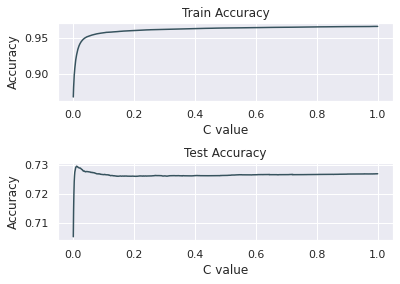

In [446]:
fig, ax= plt.subplots(2,1)
plt.subplots_adjust(hspace=0.8)

ax[0].plot(c_vals, train_accuracy_vals)
ax[0].set_xlabel('C value')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Train Accuracy')

ax[1].plot(c_vals, test_accuracy_vals)
ax[1].set_xlabel('C value')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Test Accuracy')

plt.show()


The way to control the regularization parameter for scikitlearn's logistic regression function is by changing the C parameter. It is inverse to the strength of regularization so a smaller number means stronger regularization. I thought that increasing the regularization parameter may fix the bias problem, but as seen from the graph it peaks at a little less than 0, around 0.01, and then decreases. The training accuracy also lowers as the regularization parameter is increased which is expected, but it is not promising that it lowers at the same rate as the training accuracy.

This means that there may be an inherent problem with the data. It probably stems from how the photometric qualities (u,g,r,i,z) of the stars and galaxies are very similar as well as the redshift. The redshift seems to be the defining characteristic of the quasars which allows them to be classified correctly while the stars and galaxies with similar redshifts are misclassified as each other.

Before I try to gather more data to train the model, I will try to use an SVM classifier and see if it will be able to find a better decision boundary.

## Applying a SVM on all features

For the kernel I will try to use the RBF kernel since the boundary does not seem to be linear for our data.

Classification Test Score: 0.7051 

Train Score: 0.8677404832174479 

Classification Performance:
               precision    recall  f1-score   support

           0       0.98      0.20      0.33     21535
           1       0.64      1.00      0.78     29113
           2       0.88      1.00      0.94      9352

    accuracy                           0.71     60000
   macro avg       0.83      0.73      0.68     60000
weighted avg       0.80      0.71      0.64     60000



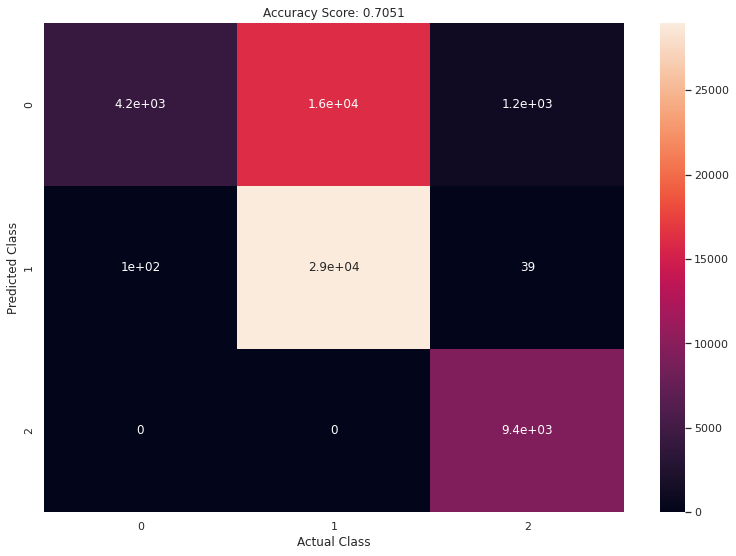

In [455]:
svm_clf = SVC()

svm_clf.fit(train_data, train_target)

predictions_svm = svm_clf.predict(cv_data)

test_accuracy_svm = svm_clf.score(cv_data, cv_target)
train_accuracy_svm = svm_clf.score(train_data, train_target)

print('Classification Test Score:', test_accuracy ,'\n')
print('Train Score:', train_accuracy, '\n')
print('Classification Performance:\n', classification_report(cv_target, predictions_svm))

cm = confusion_matrix(cv_target, predictions_svm)

fig = plt.gcf()
fig.set_size_inches(13,9)
sns.heatmap(cm, annot=True).set_title('Accuracy Score: {}'.format(test_accuracy))
plt.xlabel('Actual Class')
plt.ylabel('Predicted Class')

plt.show()

## Applying SVM with dropped features

Classification Test Score: 0.7051 

Train Score: 0.8677404832174479 

Classification Performance:
               precision    recall  f1-score   support

           0       0.97      0.14      0.24     21535
           1       0.62      1.00      0.77     29113
           2       0.90      1.00      0.94      9352

    accuracy                           0.69     60000
   macro avg       0.83      0.71      0.65     60000
weighted avg       0.79      0.69      0.61     60000



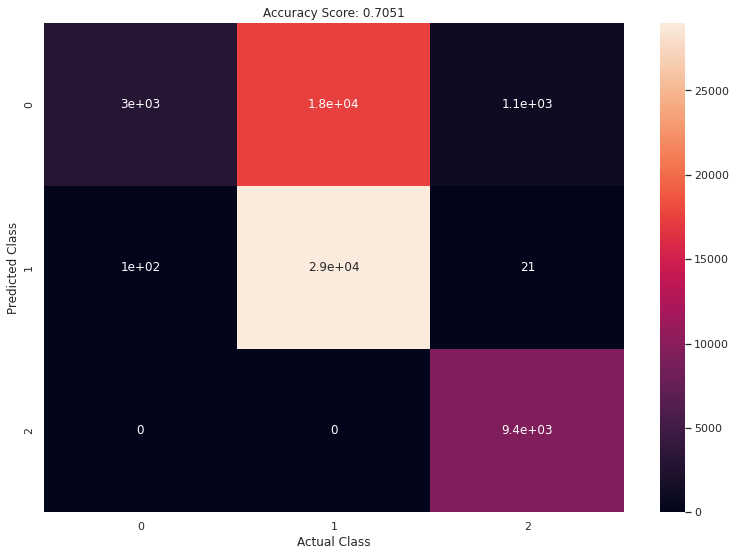

In [457]:
train_data_dropped= train_data[['u','z','redshift']]
cv_data_dropped_= cv_data[['u','z','redshift']]

svm_clf_dropped = SVC()

svm_clf_dropped.fit(train_data_dropped, train_target)

predictions_svm = svm_clf_dropped.predict(cv_data_dropped)

test_accuracy_svm = svm_clf_dropped.score(cv_data_dropped, cv_target)
train_accuracy_svm = svm_clf_dropped.score(train_data_dropped, train_target)

print('Classification Test Score:', test_accuracy ,'\n')
print('Train Score:', train_accuracy, '\n')
print('Classification Performance:\n', classification_report(cv_target, predictions_svm))

cm = confusion_matrix(cv_target, predictions_svm)

fig = plt.gcf()
fig.set_size_inches(13,9)
sns.heatmap(cm, annot=True).set_title('Accuracy Score: {}'.format(test_accuracy))
plt.xlabel('Actual Class')
plt.ylabel('Predicted Class')

plt.show()

## Applying SVM using features with PCA

Classification Test Score: 0.7128666666666666 

Train Score: 0.9354709619328698 

Classification Performance:
               precision    recall  f1-score   support

           0       0.97      0.24      0.38     21535
           1       0.65      0.99      0.79     29113
           2       0.91      1.00      0.95      9352

    accuracy                           0.72     60000
   macro avg       0.84      0.74      0.71     60000
weighted avg       0.81      0.72      0.67     60000



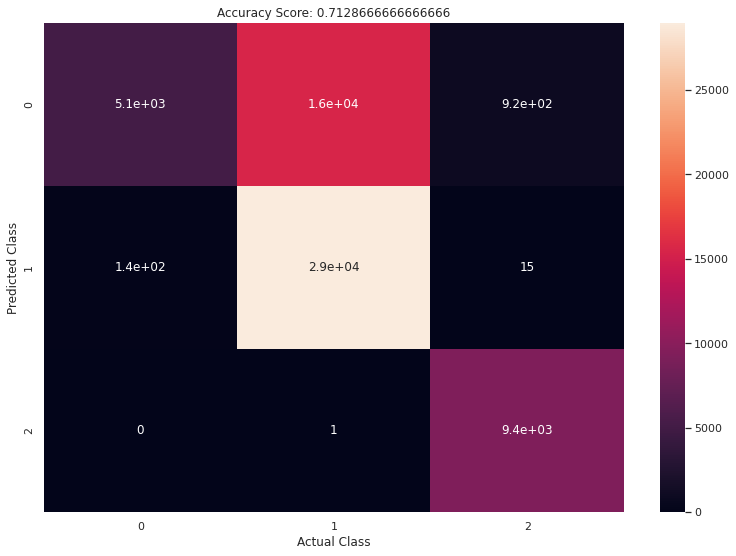

In [464]:
svm_clf_pca = SVC(kernel='poly',degree=4)

svm_clf_pca.fit(train_data_principal, train_target)
predictions_pca = svm_clf_pca.predict(cv_data_principal)

test_accuracy = svm_clf_pca.score(cv_data_principal, cv_target_principal)
train_accuracy = svm_clf_pca.score(train_data_principal, train_target)

print('Classification Test Score:', test_accuracy ,'\n')
print('Train Score:', train_accuracy, '\n')
print('Classification Performance:\n', classification_report(cv_target_principal, predictions))

cm = confusion_matrix(cv_target_principal, predictions)

fig = plt.gcf()
fig.set_size_inches(13,9)
sns.heatmap(cm, annot=True).set_title('Accuracy Score: {}'.format(test_accuracy))
plt.xlabel('Actual Class')
plt.ylabel('Predicted Class')

plt.show()

Unfortunately, it apears that the SVM could not make an accurate prediction either. This is probably due to all of the photometric qualites being clustered on top of each other as seen in the pair plot.

# Conclusion

It looks like logistic regression and SVM cannot get a very accurate prediction and seems to misclassify the galaxies and the stars the most. This is probably due to the photometric and redshift being so similar for the stars and galaxies. In the near future, I plan on adding more data to my training set to see if I can fix this inability to generalize. If the model sees more data then it is possible that it may be better at predicting the classes, but if all of the data for the stars and galaxies are similar then it is possible that more features may need to be added which would define these classes better.

Overall, the logistic regression model with the dropped features performed the best with an accuracy of 73% on the cross-validation set. Considering the low accuracy of the model, I did not try to test it on the test set. I would like to get an accuracy of at least 80% before testing it on the test set. 73% is not terrible and could be seen as a passing score since a majority of the examples are classified correctly, but it does not seem as high as it could be.